<h1><center>Lab 8 - A8</center></h1>
<h1><center>Ant Colony Optimization</center></h1>

In [1]:
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Travelling Salesman Problem (TSP)
Given a collection of N cities and the cost of travel between each pair of them, the **traveling salesman problem**, or TSP for short, is to find the cheapest way of visiting all of the cities and returning to your starting point.
  
In the standard version, the travel costs are symmetric in the sense that traveling from city X to city Y costs just as much as traveling from Y to X.
  
The solution can be represented as permutation of size N. The cost of a solution is the sum of distances
between cities in the order given by the permutation.

## TSP: prerequisites
Helper functions for TSP solution generation and evaluation

In [2]:
# TSP helper functions

def load_data(file_name):
  '''
    Loads data for TSP from a file (extension .tsp)
    Input:
      - file_name: str
    Output:
      - n: int
      - nodes: dict[int]: tuple[int, int]
  '''
  n = 0
  nodes = {}
  with open(file_name) as f:
    while True:
      line = f.readline()
      # line at beginning of file
      if line[0] >= 'A' and line[0] <= 'Z':
        # get size of dataset
        if line.split()[0] == 'DIMENSION':
          n = int(line.split()[2])
        # end of file
        elif line.strip() == 'EOF':
          break
        else:
          continue
      # line containing tsp data
      else:
        i, x, y = line.split()
        i = int(i)
        x = float(x)
        y = float(y)
        nodes[i] = (x, y)
  return n, nodes

def euclidean_distance(x, y):
  '''
    Computes the euclidean distance between two points in 2D space
    Input:
      - x: tuple[int, int]
      - y: tuple[int, int]
    Output:
      - float
  '''
  return math.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

def tsp_fitness(n, nodes, permutation):
  '''
    Calculates the total length of the tour described by the given permutation
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - permutation: list[int] -> size = n
    Output:
      - length: float
  '''
  length = 0
  for i in range(n - 1):
    length += euclidean_distance(nodes[permutation[i]], nodes[permutation[i+1]])
  length += euclidean_distance(nodes[permutation[-1]], nodes[permutation[0]])
  return length

def generate_random_permutation(n):
  '''
    Generates a random permutation of size n
    Input:
      - n: int
    Output:
      - permutation: list[int] -> size = n
  '''
  permutation = [(1 + i) for i in range(n)]
  random.shuffle(permutation)  
  return permutation

def plot_tsp(nodes, configuration):
  '''
    Plots a TSP tour with matplotlib
    Input: 
      - nodes: dict[int]: tuple[int, int]
      - configuration: list[int]
    Output: None
  '''
  x = [nodes[i][0] for i in configuration]
  x.append(x[0])

  y = [nodes[i][1] for i in configuration]
  y.append(y[0])

  plt.plot(x, y, marker='o', linestyle='-', markersize=8)
  plt.grid()
  plt.show()

# Ant System Algorithm for TSP

In [3]:
# Helper functions

def compute_distance_matrix(n, nodes):
  '''
    Computes the distance matrix for all node pairs
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
    Output:
      - matrix: np.array[n][n]
  '''
  matrix = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      if i != j:
        matrix[i][j] = euclidean_distance(nodes[i+1], nodes[j+1])
  return matrix

def initialize_pheromone_matrix(n, initial_pheromone=1.0):
  '''
    Initializes the pheromone matrix with a constant value
    Input:
      - n: int
      - initial_pheromone: float
    Output:
      - np.array[n][n]
  '''
  return np.ones((n, n)) * initial_pheromone

def compute_visibility_matrix(distance_matrix):
  '''
    Computes the visibility (1 / distance) for the Ant System
    Input:
      - distance_matrix: np.array[n][n]
    Output:
      - visibility_matrix: np.array[n][n]
  '''
  with np.errstate(divide='ignore'):
    visibility_matrix = 1 / distance_matrix
    visibility_matrix[distance_matrix == 0] = 0
  return visibility_matrix

def construct_solution(n, pheromone_matrix, visibility_matrix, alpha, beta):
  '''
    Constructs a tour using a probabilistic rule based on pheromone and visibility
    Input:
      - n: int
      - pheromone_matrix: np.array[n][n]
      - visibility_matrix: np.array[n][n]
      - alpha, beta: float
    Output:
      - tour: list[int]
  '''
  # initialize unvisited list and add random first node to tour
  unvisited = list(range(n))
  current = random.choice(unvisited)
  tour = [current]
  unvisited.remove(current)
  # loop until all nodes are added to tour
  while unvisited:
    # calculate current edge based on probability list
    probabilities = []
    for j in unvisited:
      pheromone = pheromone_matrix[current][j] ** alpha
      visibility = visibility_matrix[current][j] ** beta
      probabilities.append(pheromone * visibility)
    # standardize probabilities
    probabilities = np.array(probabilities)
    probabilities /= probabilities.sum()
    # choose next node with according probability
    next_node = np.random.choice(unvisited, p=probabilities)
    # append next node to tour, update unvisited list
    tour.append(next_node)
    unvisited.remove(next_node)
    current = next_node
  # return tour
  return tour

def update_pheromones(n, pheromone_matrix, tours, fitnesses, rho, Q):
  '''
    Applies pheromone evaporation based on pheromone trail update rule
    Input:
      - n: int
      - pheromone_matrix: np.array[n][n]
      - tours: list[list[int]]
      - fitnesses: list[int]
    Output:
      - new_pheromone_matrix: np.array[n][n]
  '''
  # apply evaporation based on evaporation rate
  new_pheromone_matrix = pheromone_matrix * (1 - rho)
  for tour, fitness in zip(tours, fitnesses):
    # calculate deposit and add it to new_pheromone
    deposit = Q / fitness
    for i in range(n):
      a = tour[i]
      b = tour[(i + 1) % n]
      new_pheromone_matrix[a][b] += deposit
      new_pheromone_matrix[b][a] += deposit
  # return updated pheromone matrix
  return new_pheromone_matrix

In [12]:
# Ant System algorithm for the Travelling Salesman Problem

def tsp_ant_system(n, nodes, num_ants=20, max_iterations=100, alpha=1.0, beta=5.0, rho=0.5, Q=100.0, initial_pheromone=1.0):
  '''
    Implements an ant system algorithm for the travelling salesman problem
    Input:
      - n: int (number of cities)
      - nodes: dict[int]: tuple[int, int] (coordinates of cities)
      - num_ants: int (number of ants per iteration)
      - max_iterations: int
      - alpha: float (pheromone influence)
      - beta: float (visibility influence)
      - rho: float (pheromone evaporation rate)
      - Q: float (pheromone deposit constant)
      - initial_pheromone: float (initial pheromone level on edges)
    Output:
      - tours: list[list[int]]
      - best_tour: list[int]
      - best_fitness: float
  '''
  # compute distance and visibility matrices
  distance_matrix = compute_distance_matrix(n, nodes)
  visibility_matrix = compute_visibility_matrix(distance_matrix)
  
  # initialize pheromone matrix
  pheromone_matrix = initialize_pheromone_matrix(n, initial_pheromone)

  # initialize best solution
  best_tour = None
  best_fitness = float('inf')
  best_fitnesses = []

  for iteration in range(max_iterations):
    tours = []
    fitnesses = []

    for _ in range(num_ants):
      # construct current tour and compute fitness
      tour = construct_solution(n, pheromone_matrix, visibility_matrix, alpha, beta)
      fitness = tsp_fitness(n, nodes, [i + 1 for i in tour])  # +1 for 1-based indexing in nodes
      tours.append(tour)
      fitnesses.append(fitness)

      # update best solution if found
      if fitness < best_fitness:
        best_fitness = fitness
        best_tour = tour

    # update pheromones
    pheromone_matrix = update_pheromones(n, pheromone_matrix, tours, fitnesses, rho, Q)

    # add best fitness to best fitnesses list
    best_fitnesses.append(min(fitnesses))


  # convert best_tour to 1-based indexing (to match original node keys)
  best_tour = [i + 1 for i in best_tour]

  return best_fitnesses, best_tour, best_fitness

Solution to TSP for 101 nodes:
Fitness: 702.6064129363187
Route found:


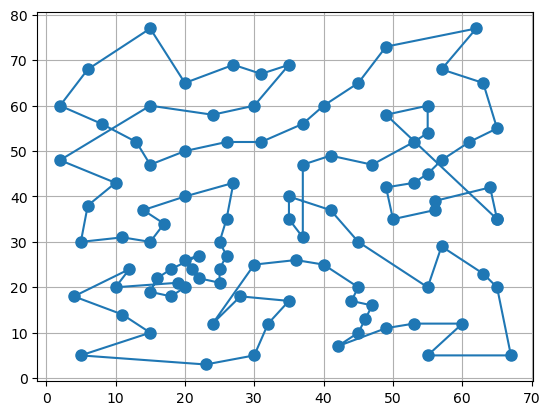

In [5]:
# Testing ant system algorithm for the small dataset

# n = 101
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

_, solution, fitness = tsp_ant_system(n, nodes, num_ants=20, max_iterations=100)

print(f"Solution to TSP for {n} nodes:")
print(f"Fitness: {solution}")

print("Route found:")
plot_tsp(nodes, fitness)

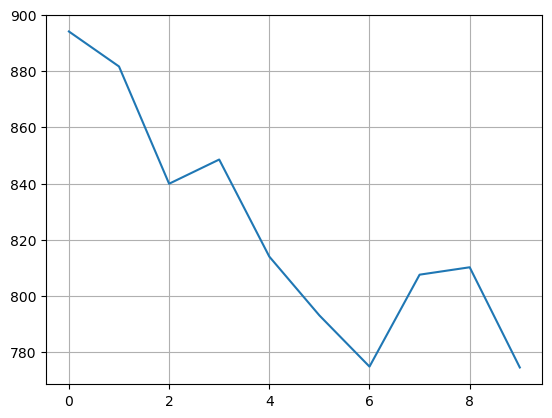

In [15]:
# Testing solution after 1 iteration and after 10 iterations for 10 ants

# n = 101
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

fitnesses, solution, fitness = tsp_ant_system(n, nodes, num_ants=10, max_iterations=10)

plt.plot(fitnesses)
plt.grid()
plt.show()